# LSTM_Approach :

### Split the signal into train and test set. Predict the test set using the model trained with train set. Compare between the test set and predicted set using the fixed window_size using either MSE or RMSE. Pick the top 5 signals with largest MSE or RMSE values which are the abnormal signals.

# Libraries to be imported

In [1]:
import numpy as np
import tensorflow as tf

# pd.options.mode.chained_assignment=None
import seaborn as sns
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import os
import wfdb

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize']=14,8
np.random.seed(1)
tf.random.set_seed(1)
print(tf.__version__)

import warnings
warnings.filterwarnings('ignore')

2.4.0


In [2]:
flist = os.listdir('../data/ECGdata/Person_01/')
flist = [file for file in flist if file.endswith('.dat')]

In [3]:
records={}
flist = os.listdir('../data/ECGdata/Person_01/')
flist = [file for file in flist if file.endswith(".dat")]   
for file in flist:
    records[file] = wfdb.rdrecord('../data/ECGdata/Person_01/'+file[:-4],channels=[1])

In [4]:
records

{'rec_8.dat': <wfdb.io.record.Record at 0x107d95bb0>,
 'rec_9.dat': <wfdb.io.record.Record at 0x107d95df0>,
 'rec_18.dat': <wfdb.io.record.Record at 0x107d95fa0>,
 'rec_19.dat': <wfdb.io.record.Record at 0x107d95c40>,
 'rec_20.dat': <wfdb.io.record.Record at 0x107d95f70>,
 'rec_11.dat': <wfdb.io.record.Record at 0x107d95520>,
 'rec_10.dat': <wfdb.io.record.Record at 0x107d959d0>,
 'rec_12.dat': <wfdb.io.record.Record at 0x107d95eb0>,
 'rec_13.dat': <wfdb.io.record.Record at 0x11c73e1f0>,
 'rec_17.dat': <wfdb.io.record.Record at 0x107d0a6d0>,
 'rec_16.dat': <wfdb.io.record.Record at 0x107d95e50>,
 'rec_14.dat': <wfdb.io.record.Record at 0x107d95460>,
 'rec_15.dat': <wfdb.io.record.Record at 0x107d95790>,
 'rec_4.dat': <wfdb.io.record.Record at 0x107d95dc0>,
 'rec_5.dat': <wfdb.io.record.Record at 0x107d95e80>,
 'rec_7.dat': <wfdb.io.record.Record at 0x107d958e0>,
 'rec_6.dat': <wfdb.io.record.Record at 0x107d95fd0>,
 'rec_2.dat': <wfdb.io.record.Record at 0x107d95400>,
 'rec_3.dat': <wf

In [5]:
series={}
for rec in records:
    series[rec]=np.ndarray.flatten(records[rec].p_signal[:])

In [7]:
# Convert the data into csv

In [9]:
import pandas as pd
import csv

In [10]:
datapd = {}
for rec in records:
    datapd[rec]=pd.DataFrame(series[rec])

In [20]:
datacsv={}
# for rec in records:
datacsv['rec_5.dat']=datapd['rec_5.dat'].to_csv('rec_5.csv',header=False)

In [30]:
# for rec in records:
u={}
for i in range(1,6):
    with open('rec_'+str(i)+'.csv','r') as csvfile:
        u['rec_'+str(i)]=[]
        file = csv.reader(csvfile,delimiter=",")
        file=list(file)
        for fi in file:
            u['rec_'+str(i)].append(float(fi[1]))

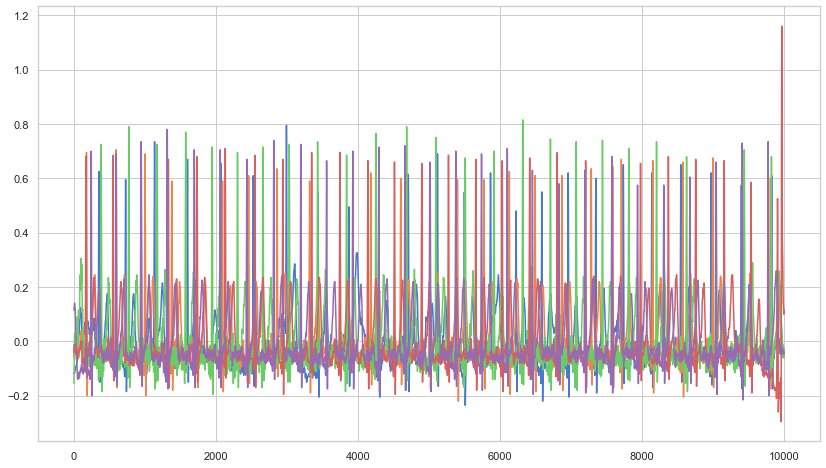

In [33]:
for i in range(1,6):
    plt.plot(u['rec_'+str(i)])

# Time series-Predict

In [57]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [58]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Dividing the data into train and test set

In [162]:
x_train={}
x_valid={}
split_time=5000
for rec in records:
    x_train[rec] = series[rec][:split_time]
    x_valid[rec] = series[rec][split_time:]

In [122]:
shuffle_buffer_size = 1000

In [99]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set={}
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
for rec in records:
    train_set[rec] = windowed_dataset(x_train[rec], window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history={}
for rec in records:
    history[rec] = model.fit(train_set[rec],epochs=500, callbacks=[callback])

Epoch 1/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0210 - mae: 0.1233
Epoch 2/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0043 - mae: 0.0627
Epoch 3/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0038 - mae: 0.0576
Epoch 4/500
50/50 [==============================] - 2s 47ms/step - loss: 0.0036 - mae: 0.0560
Epoch 5/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0035 - mae: 0.0554
Epoch 6/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0034 - mae: 0.0543
Epoch 7/500
50/50 [==============================] - 2s 48ms/step - loss: 0.0032 - mae: 0.0528
Epoch 8/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0029 - mae: 0.0504
Epoch 9/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0025 - mae: 0.0447
Epoch 10/500
50/50 [==============================] - 2s 49ms/step - loss: 0.0022 - mae: 0.0424
Epoch 11/500
50/50 [=============================

50/50 [==============================] - 2s 47ms/step - loss: 7.7498e-04 - mae: 0.0277
Epoch 168/500
50/50 [==============================] - 2s 47ms/step - loss: 7.5857e-04 - mae: 0.0272
Epoch 169/500
50/50 [==============================] - 2s 47ms/step - loss: 7.5469e-04 - mae: 0.0271
Epoch 170/500
50/50 [==============================] - 2s 46ms/step - loss: 7.5188e-04 - mae: 0.0271
Epoch 171/500
50/50 [==============================] - 2s 47ms/step - loss: 7.5447e-04 - mae: 0.0272
Epoch 172/500
50/50 [==============================] - 2s 46ms/step - loss: 7.5832e-04 - mae: 0.0273
Epoch 173/500
50/50 [==============================] - 2s 46ms/step - loss: 7.5888e-04 - mae: 0.0274
Epoch 174/500
50/50 [==============================] - 2s 47ms/step - loss: 7.6411e-04 - mae: 0.0276
Epoch 175/500
50/50 [==============================] - 2s 47ms/step - loss: 7.4834e-04 - mae: 0.0271
Epoch 176/500
50/50 [==============================] - 2s 47ms/step - loss: 7.6389e-04 - mae: 0.0276
Epoc

50/50 [==============================] - 2s 47ms/step - loss: 6.0557e-04 - mae: 0.0248
Epoch 330/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0268e-04 - mae: 0.0247
Epoch 331/500
50/50 [==============================] - 2s 47ms/step - loss: 6.1505e-04 - mae: 0.0251
Epoch 332/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0154e-04 - mae: 0.0247
Epoch 333/500
50/50 [==============================] - 2s 47ms/step - loss: 5.9967e-04 - mae: 0.0246
Epoch 334/500
50/50 [==============================] - 2s 47ms/step - loss: 5.9814e-04 - mae: 0.0246
Epoch 335/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0227e-04 - mae: 0.0247
Epoch 336/500
50/50 [==============================] - 2s 47ms/step - loss: 6.0262e-04 - mae: 0.0247
Epoch 337/500
50/50 [==============================] - 2s 47ms/step - loss: 5.9915e-04 - mae: 0.0246
Epoch 338/500
50/50 [==============================] - 2s 48ms/step - loss: 5.9538e-04 - mae: 0.0245
Epoc

50/50 [==============================] - 3s 59ms/step - loss: 5.2041e-04 - mae: 0.0230
Epoch 492/500
50/50 [==============================] - 3s 60ms/step - loss: 5.2140e-04 - mae: 0.0231
Epoch 493/500
50/50 [==============================] - 3s 58ms/step - loss: 5.2141e-04 - mae: 0.0231
Epoch 494/500
50/50 [==============================] - 2s 48ms/step - loss: 5.1875e-04 - mae: 0.0230
Epoch 495/500
50/50 [==============================] - 3s 63ms/step - loss: 5.1950e-04 - mae: 0.0230
Epoch 496/500
50/50 [==============================] - 3s 51ms/step - loss: 5.2219e-04 - mae: 0.0231
Epoch 497/500
50/50 [==============================] - 3s 53ms/step - loss: 5.2574e-04 - mae: 0.0233
Epoch 498/500
50/50 [==============================] - 2s 48ms/step - loss: 5.1604e-04 - mae: 0.0229
Epoch 499/500
50/50 [==============================] - 3s 53ms/step - loss: 5.2535e-04 - mae: 0.0233
Epoch 500/500
50/50 [==============================] - 2s 50ms/step - loss: 5.1574e-04 - mae: 0.0229
Epoc

50/50 [==============================] - 3s 50ms/step - loss: 7.0298e-04 - mae: 0.0270
Epoch 155/500
50/50 [==============================] - 3s 61ms/step - loss: 6.8886e-04 - mae: 0.0266
Epoch 156/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8841e-04 - mae: 0.0266
Epoch 157/500
50/50 [==============================] - 2s 50ms/step - loss: 6.9511e-04 - mae: 0.0268
Epoch 158/500
50/50 [==============================] - 3s 53ms/step - loss: 6.8717e-04 - mae: 0.0266
Epoch 159/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8554e-04 - mae: 0.0265
Epoch 160/500
50/50 [==============================] - 3s 54ms/step - loss: 6.8563e-04 - mae: 0.0266
Epoch 161/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8973e-04 - mae: 0.0267
Epoch 162/500
50/50 [==============================] - 3s 54ms/step - loss: 6.8764e-04 - mae: 0.0266
Epoch 163/500
50/50 [==============================] - 3s 55ms/step - loss: 6.8539e-04 - mae: 0.0266
Epoc

50/50 [==============================] - 3s 53ms/step - loss: 6.1725e-04 - mae: 0.0254
Epoch 317/500
50/50 [==============================] - 3s 53ms/step - loss: 6.1722e-04 - mae: 0.0254
Epoch 318/500
50/50 [==============================] - 3s 51ms/step - loss: 6.1915e-04 - mae: 0.0254
Epoch 319/500
50/50 [==============================] - 3s 55ms/step - loss: 6.1749e-04 - mae: 0.0254
Epoch 320/500
50/50 [==============================] - 3s 51ms/step - loss: 6.1574e-04 - mae: 0.0254
Epoch 321/500
50/50 [==============================] - 3s 51ms/step - loss: 6.2079e-04 - mae: 0.0255
Epoch 322/500
50/50 [==============================] - 3s 51ms/step - loss: 6.2430e-04 - mae: 0.0256
Epoch 323/500
50/50 [==============================] - 3s 51ms/step - loss: 6.1758e-04 - mae: 0.0255
Epoch 324/500
50/50 [==============================] - 3s 51ms/step - loss: 6.2237e-04 - mae: 0.0256
Epoch 325/500
50/50 [==============================] - 3s 52ms/step - loss: 6.1570e-04 - mae: 0.0254
Epoc

50/50 [==============================] - 2s 49ms/step - loss: 5.7094e-04 - mae: 0.0246
Epoch 479/500
50/50 [==============================] - 2s 49ms/step - loss: 5.7130e-04 - mae: 0.0246
Epoch 480/500
50/50 [==============================] - 2s 49ms/step - loss: 5.7050e-04 - mae: 0.0246
Epoch 481/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7178e-04 - mae: 0.0246
Epoch 482/500
50/50 [==============================] - 2s 48ms/step - loss: 5.6787e-04 - mae: 0.0245
Epoch 483/500
50/50 [==============================] - 2s 48ms/step - loss: 5.6869e-04 - mae: 0.0245
Epoch 484/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7048e-04 - mae: 0.0246
Epoch 485/500
50/50 [==============================] - 2s 49ms/step - loss: 5.6941e-04 - mae: 0.0246
Epoch 486/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7250e-04 - mae: 0.0247
Epoch 487/500
50/50 [==============================] - 2s 48ms/step - loss: 5.7007e-04 - mae: 0.0246
Epoc

In [116]:
rnn_forecast={}
for rec in records:
    rnn_forecast[rec] = model_forecast(model, series[rec][...,np.newaxis], window_size)
    rnn_forecast[rec] = rnn_forecast[rec][split_time-window_size:-1, -1, 0]

# Plot to check the actual data vs Predicted data

NameError: name 'rnn_forecast' is not defined

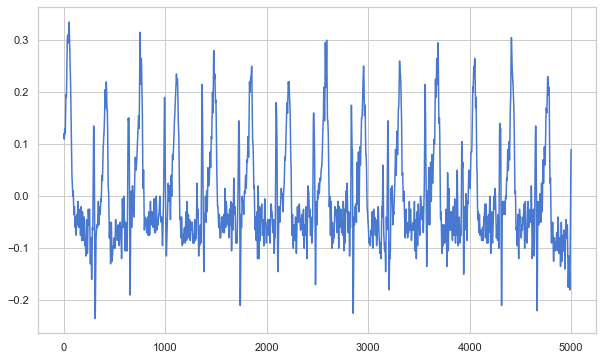

In [164]:
plt.figure(figsize=(10, 6))
for rec in records:
    plt.plot(x_valid[rec])
    plt.plot(rnn_forecast[rec][:])
    plt.show()

# Compare between Actual and Predicted signal using MSE Approach

In [303]:
def find_cmp_dd_detect(data,pred,win_size):
    p,q,cnt=0,0,1
    best_so_far=0
    cmp_=[]
    rm_=[]
    while win_size*cnt<len(data):
        sum1=0
        rmse_=0
        p=data[:win_size*cnt]
        q=pred[:win_size*cnt]
        for k in range(len(p)):
            m=len(p)
            sum1=sum1+((abs(p[k]-q[k]))**2)
            rmse_=(sum1)/m
            
        if rmse_ not in rm_:
            cmp_.append([rmse_,win_size*cnt])
            rm_.append(rmse_)
        cnt+=1
    return cmp_

In [304]:
cmp_discords={}
num_discords=5
win_size=200
cmp_max_discords={}
for rec in records: 
    cmp_discords[rec]=find_cmp_dd_detect(x_valid[rec],rnn_forecast[rec],win_size)

# Pick the top 5 discords

In [305]:
def max_cmp(cmp_,num_discords):
    maxi = []
    val = []
    rm_ = []
    for i in range(len(cmp_)):
        rm_.append(cmp_[i][0])
    for i in range(num_discords):
        best_so_far=None
        for j in rm_:
            if best_so_far == None:
                best_so_far = j
            elif best_so_far < j:
                best_so_far = j
        rm_.remove(best_so_far)
        maxi.append(best_so_far)
        for j in cmp_:
            if best_so_far == j[0]:
                val.append([j[0],j[1]])
    return val

In [306]:
cmp_max_dd={}
for rec in records:
    cmp_max_dd[rec] = max_cmp(cmp_discords[rec],num_discords)

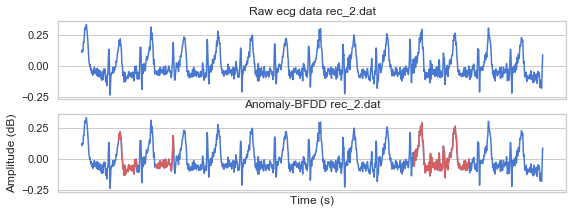

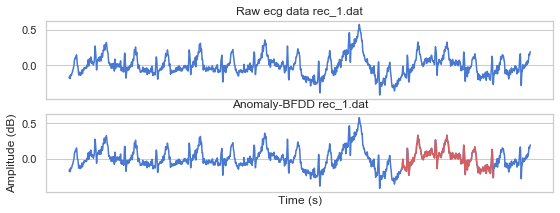

In [307]:
figsize = (20, 10)

ymin={}
ymax={}

for rec in records:
    plt.figure(figsize=figsize)

    plt.subplot2grid((6, 2), (0, 0))
    # plt.subplot(621)
    # plt.figure(1, figsize=left_figsize)
    # plt.clf()
    plt.xticks([])
    plt.plot(x_valid[rec])
    plt.title("Raw ecg data "+str(rec))
    plt.grid(True)
    
    ymin[rec] = np.min(x_valid[rec])
    ymax[rec] = np.max(x_valid[rec])
    alpha = 0.2 * (ymax[rec] - ymin[rec])
    ymax[rec] += alpha
    ymin[rec] -= alpha
    
    plt.subplot2grid((6, 2), (1, 0))
    plt.xticks([])
    # plt.clf()
    plt.ylabel("Amplitude (dB)")
    # Calculate time values in seconds
    times = np.arange(x_valid[rec].shape[0], dtype='float')
    plt.xlabel("Time (s)")
    plt.plot(x_valid[rec],color='b')
    for i in range(len(cmp_max_dd[rec])):
        indrpk1 = cmp_max_dd[rec][i][1]
#         plt.plot(np.concatenate((data[rec][:r_peaks[rec][int(max_dd[rec][i])+(map_sum[rec][0])]-1],data[rec][r_peaks[rec][int(max_dd[rec][i])]+1:r_peaks[rec][int(max_dd[rec][i])+1]]),axis=0),color='b')
        plt.plot(range(indrpk1+1,indrpk1+win_size+1),x_valid[rec][indrpk1+1:indrpk1+win_size+1],color='r')
    plt.title("Anomaly-BFDD "+str(rec))
    
    plt.grid(True)

# <font color='red'>Stacked_LSTM_Approach (Unlabelled data)</font> - <font color='orange'>Paper : Paper10</font>

## <font color='blue'>1) Threshold_Approach</font>

## Step 1 : Data Preparation : Scale or normalize between the range [-1, 1]

## Step 2 : Split the data into training ( 80% ) and testing ( 20% )

## Step 3 : Train the model using training data

## Step 4 : Input whole data and obtain y^

## Step 5 : Window based error correction

## Step 6 : Compute Prediction Erros  : E = Y - Y^

## Step 7 : Remove outliers from Prediction Errors

## Step 8 : Estimating Multivariate Gaussian Distribution

## Step 9 : Anomaly Detection : Points with Mahalanobis Distance > Threshold




In [173]:
flist = os.listdir('../data/ECGdata/Person_90/')
flist = [file for file in flist if file.endswith('.dat')]

In [174]:
records={}
flist = os.listdir('../data/ECGdata/Person_90/')
flist = [file for file in flist if file.endswith(".dat")]   
for file in flist:
    records[file] = wfdb.rdrecord('../data/ECGdata/Person_90/'+file[:-4],channels=[1])

In [175]:
series={}
for rec in records:
    series[rec]=np.ndarray.flatten(records[rec].p_signal[:])

In [186]:
# Normalize the data
a,b=-1,1

norm={}
for rec in records:
    norm[rec]=[]
    for val in series[rec]:
        n = (b-a)*((val-min(series[rec]))/(max(series[rec])-min(series[rec])))+a
        norm[rec].append(n)

In [191]:
train_data={}
test_data={}
for rec in records:
    train_data[rec]=norm[rec][:int(len(series[rec])*0.8)]
    test_data[rec]=norm[rec][int(len(series[rec])*0.8):]

In [317]:
shuffle_buffer_size=1000
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set={}
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
for rec in records:
    train_set[rec] = windowed_dataset(train_data[rec], window_size=64, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history={}
for rec in records:
#     history[rec] = model.fit(train_set[rec],epochs=500, callbacks=[callback])
    history[rec] = model.fit(train_set[rec],epochs=500)

Epoch 1/500
80/80 [==============================] - 4s 56ms/step - loss: 0.0541 - mae: 0.2179
Epoch 2/500
80/80 [==============================] - 5s 63ms/step - loss: 0.0162 - mae: 0.1352
Epoch 3/500
80/80 [==============================] - 4s 55ms/step - loss: 0.0124 - mae: 0.1180
Epoch 4/500
80/80 [==============================] - 4s 54ms/step - loss: 0.0103 - mae: 0.1061
Epoch 5/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0091 - mae: 0.0993
Epoch 6/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0080 - mae: 0.0931
Epoch 7/500
80/80 [==============================] - 4s 55ms/step - loss: 0.0067 - mae: 0.0849
Epoch 8/500
80/80 [==============================] - 4s 54ms/step - loss: 0.0063 - mae: 0.0826
Epoch 9/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0062 - mae: 0.0820
Epoch 10/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0059 - mae: 0.0796
Epoch 11/500
80/80 [=============================

80/80 [==============================] - 4s 53ms/step - loss: 0.0025 - mae: 0.0524
Epoch 171/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0025 - mae: 0.0524
Epoch 172/500
80/80 [==============================] - 5s 64ms/step - loss: 0.0025 - mae: 0.0526
Epoch 173/500
80/80 [==============================] - 5s 61ms/step - loss: 0.0025 - mae: 0.0524
Epoch 174/500
80/80 [==============================] - 6s 69ms/step - loss: 0.0025 - mae: 0.0520
Epoch 175/500
80/80 [==============================] - 5s 60ms/step - loss: 0.0025 - mae: 0.0527
Epoch 176/500
80/80 [==============================] - 5s 62ms/step - loss: 0.0025 - mae: 0.0531
Epoch 177/500
80/80 [==============================] - 4s 54ms/step - loss: 0.0025 - mae: 0.0522
Epoch 178/500
80/80 [==============================] - 4s 54ms/step - loss: 0.0025 - mae: 0.0519
Epoch 179/500
80/80 [==============================] - 5s 58ms/step - loss: 0.0025 - mae: 0.0522
Epoch 180/500
80/80 [=======================

80/80 [==============================] - 4s 52ms/step - loss: 0.0020 - mae: 0.0465
Epoch 339/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0019 - mae: 0.0462
Epoch 340/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0020 - mae: 0.0463
Epoch 341/500
80/80 [==============================] - 4s 52ms/step - loss: 0.0019 - mae: 0.0461
Epoch 342/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0019 - mae: 0.0461
Epoch 343/500
80/80 [==============================] - 4s 52ms/step - loss: 0.0019 - mae: 0.0463
Epoch 344/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0019 - mae: 0.0461
Epoch 345/500
80/80 [==============================] - 4s 52ms/step - loss: 0.0019 - mae: 0.0460
Epoch 346/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0019 - mae: 0.0461
Epoch 347/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0020 - mae: 0.0464
Epoch 348/500
80/80 [=======================

80/80 [==============================] - 4s 53ms/step - loss: 9.5112e-04 - mae: 0.0322
Epoch 7/500
80/80 [==============================] - 4s 53ms/step - loss: 9.5777e-04 - mae: 0.0324
Epoch 8/500
80/80 [==============================] - 5s 57ms/step - loss: 9.3716e-04 - mae: 0.0320
Epoch 9/500
80/80 [==============================] - 5s 57ms/step - loss: 9.2446e-04 - mae: 0.0318
Epoch 10/500
80/80 [==============================] - 4s 53ms/step - loss: 9.1406e-04 - mae: 0.0316
Epoch 11/500
80/80 [==============================] - 4s 53ms/step - loss: 9.0511e-04 - mae: 0.0315
Epoch 12/500
80/80 [==============================] - 4s 52ms/step - loss: 8.9505e-04 - mae: 0.0313
Epoch 13/500
80/80 [==============================] - 4s 52ms/step - loss: 9.0290e-04 - mae: 0.0315
Epoch 14/500
80/80 [==============================] - 4s 52ms/step - loss: 8.8603e-04 - mae: 0.0312
Epoch 15/500
80/80 [==============================] - 4s 52ms/step - loss: 8.9399e-04 - mae: 0.0314
Epoch 16/500
80/

80/80 [==============================] - 4s 53ms/step - loss: 7.8561e-04 - mae: 0.0297
Epoch 89/500
80/80 [==============================] - 4s 52ms/step - loss: 7.8186e-04 - mae: 0.0296
Epoch 90/500
80/80 [==============================] - 4s 52ms/step - loss: 7.8952e-04 - mae: 0.0298
Epoch 91/500
80/80 [==============================] - 4s 52ms/step - loss: 7.8319e-04 - mae: 0.0296
Epoch 92/500
80/80 [==============================] - 4s 52ms/step - loss: 7.8204e-04 - mae: 0.0296
Epoch 93/500
80/80 [==============================] - 4s 53ms/step - loss: 7.8728e-04 - mae: 0.0298
Epoch 94/500
80/80 [==============================] - 4s 52ms/step - loss: 7.7773e-04 - mae: 0.0295
Epoch 95/500
80/80 [==============================] - 4s 53ms/step - loss: 7.7817e-04 - mae: 0.0296
Epoch 96/500
80/80 [==============================] - 4s 52ms/step - loss: 7.8060e-04 - mae: 0.0296
Epoch 97/500
80/80 [==============================] - 4s 52ms/step - loss: 7.8711e-04 - mae: 0.0298
Epoch 98/500


80/80 [==============================] - 4s 53ms/step - loss: 7.0364e-04 - mae: 0.0281
Epoch 251/500
80/80 [==============================] - 4s 53ms/step - loss: 6.9821e-04 - mae: 0.0280
Epoch 252/500
80/80 [==============================] - 4s 53ms/step - loss: 6.9566e-04 - mae: 0.0279
Epoch 253/500
80/80 [==============================] - 5s 57ms/step - loss: 6.9878e-04 - mae: 0.0280
Epoch 254/500
80/80 [==============================] - 5s 57ms/step - loss: 6.9414e-04 - mae: 0.0279
Epoch 255/500
80/80 [==============================] - 4s 54ms/step - loss: 7.0044e-04 - mae: 0.0280
Epoch 256/500
80/80 [==============================] - 4s 54ms/step - loss: 7.0811e-04 - mae: 0.0282
Epoch 257/500
80/80 [==============================] - 4s 55ms/step - loss: 7.0732e-04 - mae: 0.0282
Epoch 258/500
80/80 [==============================] - 4s 54ms/step - loss: 6.9716e-04 - mae: 0.0279
Epoch 259/500
80/80 [==============================] - 5s 58ms/step - loss: 6.9203e-04 - mae: 0.0278
Epoc

80/80 [==============================] - 4s 53ms/step - loss: 6.6057e-04 - mae: 0.0273
Epoch 413/500
80/80 [==============================] - 4s 53ms/step - loss: 6.5846e-04 - mae: 0.0272
Epoch 414/500
80/80 [==============================] - 4s 56ms/step - loss: 6.5401e-04 - mae: 0.0271
Epoch 415/500
80/80 [==============================] - 4s 53ms/step - loss: 6.4906e-04 - mae: 0.0270
Epoch 416/500
80/80 [==============================] - 4s 53ms/step - loss: 6.5942e-04 - mae: 0.0273
Epoch 417/500
80/80 [==============================] - 4s 52ms/step - loss: 6.4898e-04 - mae: 0.0270
Epoch 418/500
80/80 [==============================] - 4s 53ms/step - loss: 6.4926e-04 - mae: 0.0270
Epoch 419/500
80/80 [==============================] - 4s 52ms/step - loss: 6.5155e-04 - mae: 0.0271
Epoch 420/500
80/80 [==============================] - 4s 53ms/step - loss: 6.4673e-04 - mae: 0.0269
Epoch 421/500
80/80 [==============================] - 4s 53ms/step - loss: 6.4509e-04 - mae: 0.0269
Epoc

In [328]:
# Inputting the whole data
rnn_forecast={}
for rec in records:
    window_size=split_time=5
    rnn_forecast[rec] = model_forecast(model, norm[rec][...,np.newaxis], window_size)
    rnn_forecast[rec] = rnn_forecast[rec][window_size-split_time:-1, -1, 0]

In [323]:
for rec in records:
    norm[rec]=np.array(norm[rec])

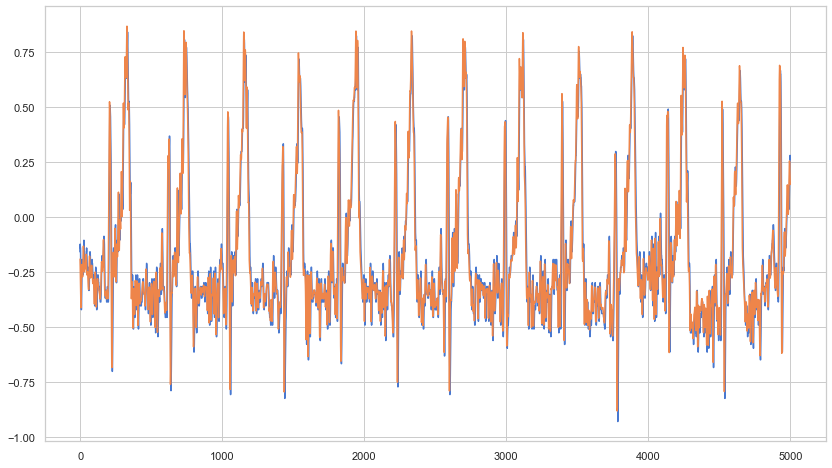

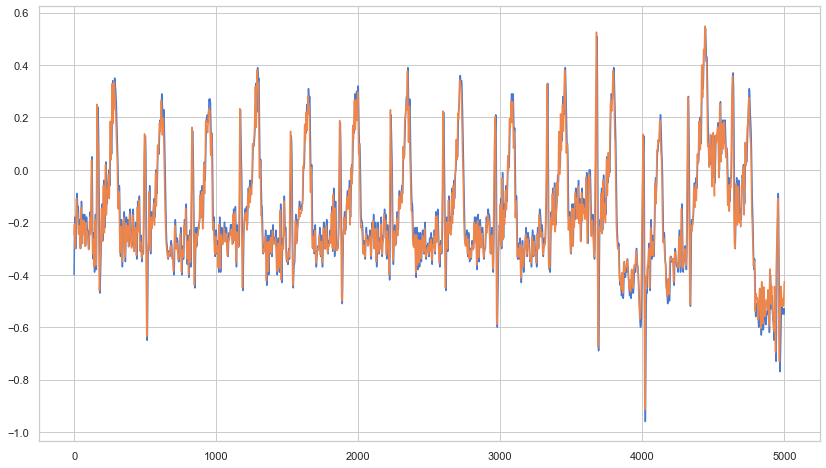

In [402]:
for rec in records:
    plt.plot(norm[rec][:5000])
    plt.plot(rnn_forecast[rec][:5000])
    plt.show()

In [ ]:
# Window based error detection



In [332]:
# Prediction error

error={}
for rec in records:
    error[rec]=[]
    for i in range(len(rnn_forecast[rec])):
        error[rec].append(norm[rec][i]-rnn_forecast[rec][i])
    error[rec]=np.array(error[rec])

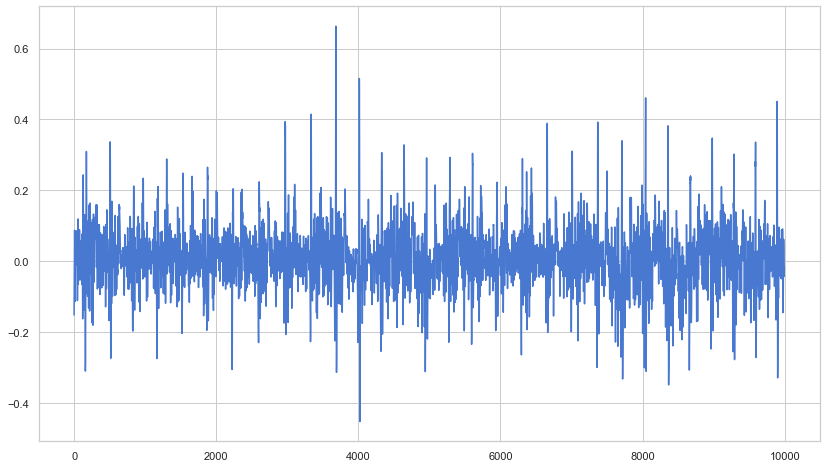

In [403]:
plt.plot(error['rec_1.dat'])

In [405]:
# Mahalanobis Distance

cov={}
cov_inv={}
dist={}
for rec in records:
    mean=error[rec].mean()

    err = np.expand_dims(error[rec],axis=0)
    cov[rec]=((err-mean)*((err-mean).T))/(len(err[0])-1)
    print(cov[rec].shape)
#     cov_inv[rec]=np.linalg.inv(cov[rec])
#     print(cov_inv[rec])
#     dist[rec]=((err-mean).T)*cov_inv[rec]*(err-mean)

(9995, 9995)
(9995, 9995)


In [ ]:
# Anomaly detection

Threshold=

anomaly={}
for rec in records:
    anomaly[rec]=dist[rec][dist>Threshold

## <font color='blue'>2) Threshold-Free Anomaly Detection</font> : <font color='orange'>Extended Rosner test</font>

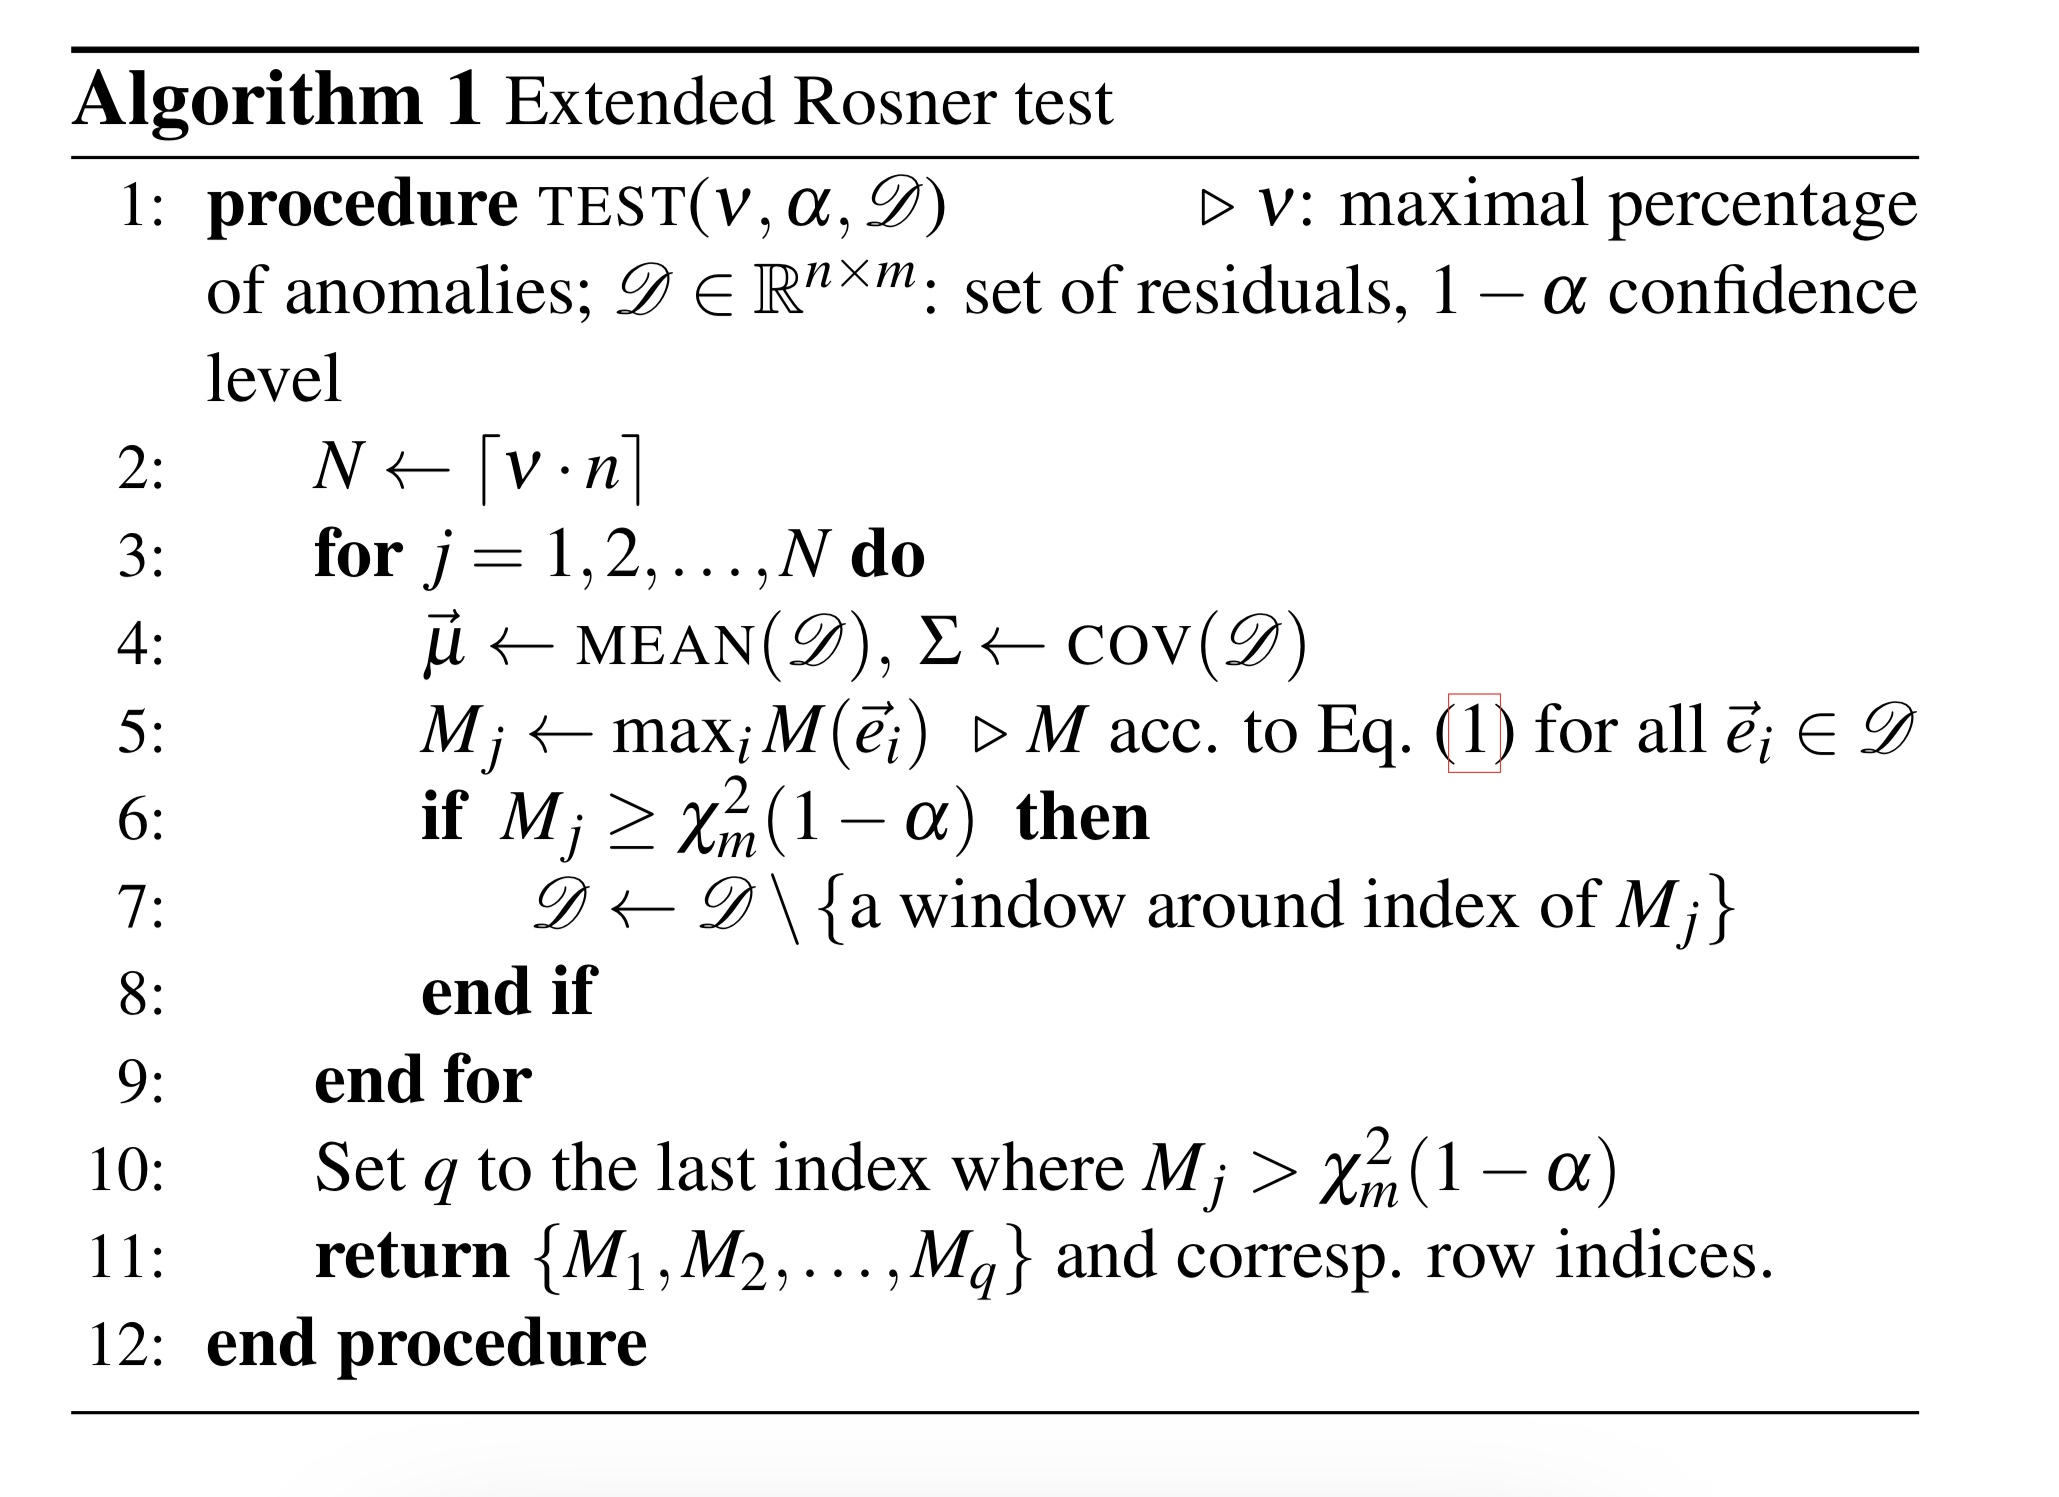

In [171]:
from IPython.display import Image
Image(filename='Threshold_free.jpg') 

In [12]:
# Extended Rosner test Algorithm

def test(v,a,D):
    N = int(v*n)
    M=[None for i in range(N)]
    ind=0
    for j in range(len(N)):
        mean = D.mean()
        cov = (D-mean)*((D-mean).T)/(len(D)-1)
        M[j]= max(M(e))
        if M[j] > xm(1-a):
            D = D/(a window around index of M[j])
            ind=j
    q = ind
    return M,q

SyntaxError: invalid syntax (<ipython-input-12-e969c5518c63>, line 12)

## -------------------------------------------------------------------

# <font color = 'red'>Stacked_LSTM_Approach ( Labelled data ) </font>- <font color = 'orange'>Paper : S Chauhan et al.</font>

## Step 1 : Train the model on Normal signals.

## Step 2 : Provide an input of fixed window and predict the actual values using the model.

## Step 3 : Obtain the error vector by taking the diff. between actual and original values.

## Step 4 :  Second stage model input

## Step 5 : MLP ( Multi-layer perception)

## Step 6 : Logistic Regression

## Step 7 : Support Vector Machine

## Step 8 : Evaluate

In [2]:
flist_normal = os.listdir('../data/qtData/Data/Normal/')
flist_abnormal = os.listdir('../data/qtData/Data/Abnormal')

flist_normal = [file for file in flist_normal if file.endswith('.dat')]
flist_abnormal = [file for file in flist_abnormal if file.endswith('.dat')]

# To include one file from normal and one from abnormal list

In [27]:
# flist = []
# flist.append(flist_normal[-1])
# flist.append(flist_abnormal[0])
# flist_normal,flist_abnormal = [],[]
# flist_normal.append(flist[0])
# flist_abnormal.append(flist[1])

In [25]:
# records_normal,records_abnormal={},{}
records={}
for file in flist_normal:
    records[file] = wfdb.rdrecord('../data/qtData/Data/Normal/'+file[:-4],channels=[1])
for file in flist_abnormal:
    records[file] = wfdb.rdrecord('../data/qtData/Data/Abnormal/'+file[:-4],channels=[1])

In [28]:
series={}
for rec in records:
    series[rec] = np.ndarray.flatten(records[rec].p_signal[:20000])

In [5]:
# series_ab={}
# for rec in records_abnormal:
#     series_ab[rec] = np.ndarray.flatten(records_abnormal[rec].p_signal[:20000])

In [29]:
series

{'sel16265.dat': array([-0.055, -0.06 , -0.065, ..., -0.13 , -0.11 , -0.095]),
 'sel123.dat': array([-0.57 , -0.555, -0.545, ..., -0.45 , -0.475, -0.47 ])}

In [32]:
records['sel16265.dat']

In [40]:
# records_normal = {}
# records_normal.update(records)
# records_normal.pop('sel123.dat')
# records_abnormal = {}
# records_abnormal.update(records)
# records_abnormal.pop('sel16265.dat')

In [42]:
Data={}
for rec in records:
    Data[rec]=[]
    if rec in records_normal:
        Data[rec].append([series[rec],[0]])
    else:
        Data[rec].append([series[rec],[1]])

In [43]:
Data['sel16265.dat']

[[array([-0.055, -0.06 , -0.065, ..., -0.13 , -0.11 , -0.095]), [0]]]

In [44]:
train_data,train_label={},{}
test_data,test_label={},{}
for rec in records:
    train_data[rec]=Data[rec][0][0][:int(len(Data[rec][0][0])*0.8)]
    train_label[rec]=Data[rec][0][1][0]
    test_data[rec]=Data[rec][0][0][int(len(Data[rec][0][0])*0.8):]
    test_label[rec]=Data[rec][0][1][0]

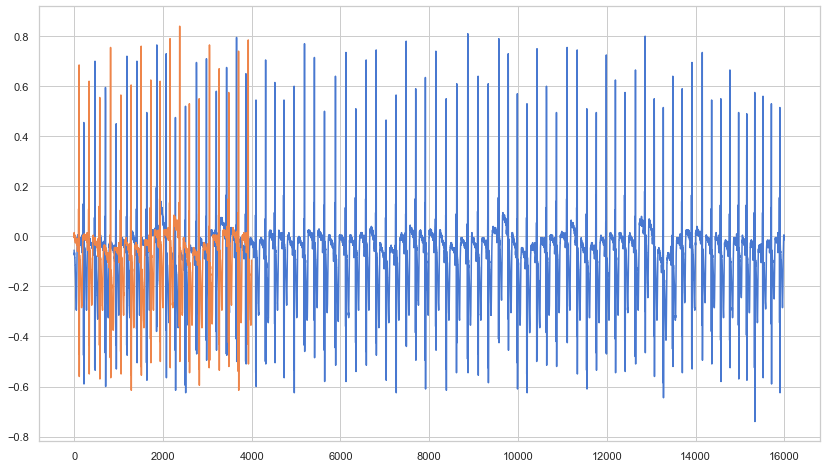

In [47]:
plt.plot(train_data['sel16265.dat'])
plt.plot(test_data['sel16265.dat'])

In [49]:
series

{'sel16265.dat': array([-0.055, -0.06 , -0.065, ..., -0.13 , -0.11 , -0.095]),
 'sel123.dat': array([-0.57 , -0.555, -0.545, ..., -0.45 , -0.475, -0.47 ])}

In [50]:
# # Normalize the data
a,b=-1,1

norm={}
for rec in records:
    norm[rec]=[]
    for val in series[rec]:
        n = (b-a)*((val-min(series[rec]))/(max(series[rec])-min(series[rec])))+a
        norm[rec].append(n)
    norm[rec]=np.array(norm[rec])

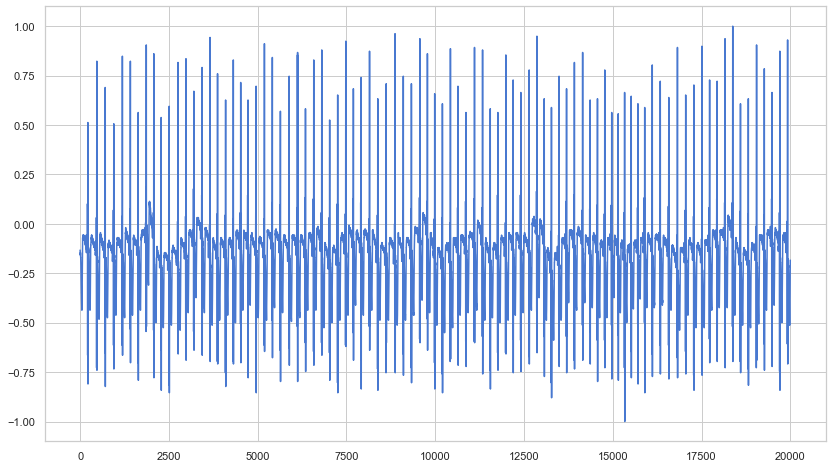

In [54]:
plt.plot(norm['sel16265.dat'])

In [36]:
# Normalize the data
# a,b=-1,1

# norm_ab={}
# for rec in records_abnormal:
#     norm_ab[rec]=[]
#     for val in series_ab[rec]:
#         n = (b-a)*((val-min(series_ab[rec]))/(max(series_ab[rec])-min(series_ab[rec])))+a
#         norm_ab[rec].append(n)
#     norm_ab[rec]=np.array(norm_ab[rec])

In [60]:
train_data={}
test_data={}
for rec in records:
    train_data[rec]=norm[rec][int(len(series[rec])*0.8):]


In [330]:
for rec in records:
    test_data[rec]=norm[rec][int(len(series[rec])*0.8):]

In [61]:
shuffle_buffer_size=1000
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set={}
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
for rec in records:
    train_set[rec] = windowed_dataset(train_data[rec], window_size=64, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history={}
for rec in records:
#     history[rec] = model.fit(train_set[rec],epochs=500, callbacks=[callback])
    history[rec] = model.fit(train_set[rec],epochs=100)

Epoch 1/100
40/40 [==============================] - 5s 56ms/step - loss: 0.0290 - mae: 0.1736
Epoch 2/100
40/40 [==============================] - 2s 59ms/step - loss: 0.0102 - mae: 0.0836
Epoch 3/100
40/40 [==============================] - 2s 54ms/step - loss: 0.0087 - mae: 0.0703
Epoch 4/100
40/40 [==============================] - 3s 60ms/step - loss: 0.0084 - mae: 0.0697
Epoch 5/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0076 - mae: 0.0652
Epoch 6/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0075 - mae: 0.0647
Epoch 7/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0072 - mae: 0.0625
Epoch 8/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0070 - mae: 0.0614
Epoch 9/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0069 - mae: 0.0597
Epoch 10/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0067 - mae: 0.0601
Epoch 11/100
40/40 [=============================

40/40 [==============================] - 2s 52ms/step - loss: 0.0017 - mae: 0.0327
Epoch 72/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0017 - mae: 0.0327
Epoch 73/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0017 - mae: 0.0329
Epoch 74/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0017 - mae: 0.0332
Epoch 75/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0017 - mae: 0.0335
Epoch 76/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0017 - mae: 0.0332
Epoch 77/100
40/40 [==============================] - 2s 53ms/step - loss: 0.0016 - mae: 0.0328
Epoch 78/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0016 - mae: 0.0325
Epoch 79/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0016 - mae: 0.0331
Epoch 80/100
40/40 [==============================] - 2s 52ms/step - loss: 0.0017 - mae: 0.0335
Epoch 81/100
40/40 [==============================] -

# Second Stage Model Inputs

### a) Predict an entire signal

In [63]:
rnn_forecast={}
for rec in records:
    rnn_forecast[rec]={}
    for i in range(10):
        window_size=split_time=5
        rnn_forecast[rec][i] = model_forecast(model, train_data[rec][...,np.newaxis], window_size)
        rnn_forecast[rec][i] = rnn_forecast[rec][i][window_size-split_time:-1, -1, 0]

In [ ]:
# for rec in records:
#     plt.plot(rnn_forecast[rec])
#     plt.plot(norm_ab[rec])
#     break

In [71]:
rnn_forecast['sel16265.dat']

{0: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 1: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 2: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 3: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 4: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 5: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 6: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 7: array([-0.08577102, -0.09564201, -0.10094282, ..., -0.22235315,
        -0.20843048, -0.19140396], dtype=float32),
 8: array([-0.08577102, -0.09564201, -0.10094282

### b) Compute the error vector : E = Yact - Ypred

In [84]:
error={}
for rec in records:
    error[rec]={}
    for i in range(10):
        error[rec][i]=[]
        for j in range(len(rnn_forecast[rec][i])):
            error[rec][i].append(test_data[rec][j]-rnn_forecast[rec][i][j])
        error[rec][i]=np.array(error[rec][i])

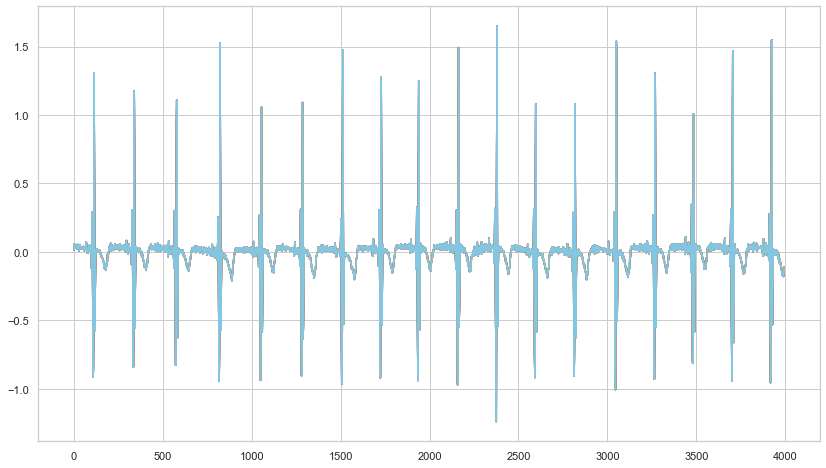

In [88]:
for i in range(10):
    plt.plot(error['sel16265.dat'][i])

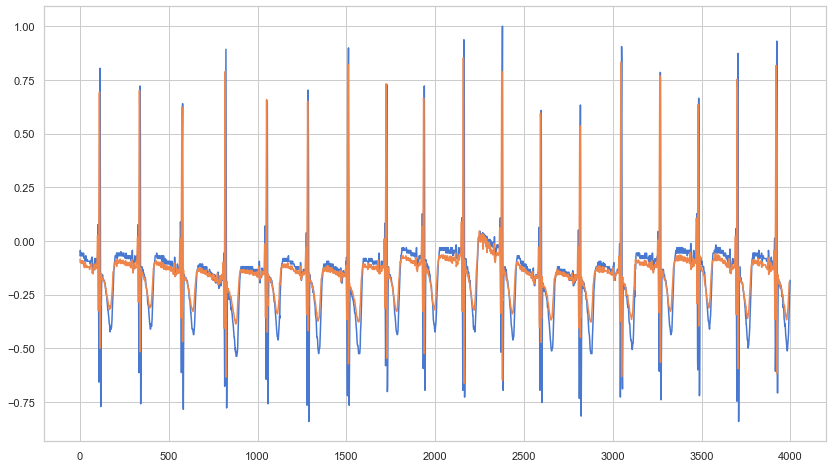

In [91]:
plt.plot(test_data['sel16265.dat'])
plt.plot(rnn_forecast['sel16265.dat'][0])
plt.show()

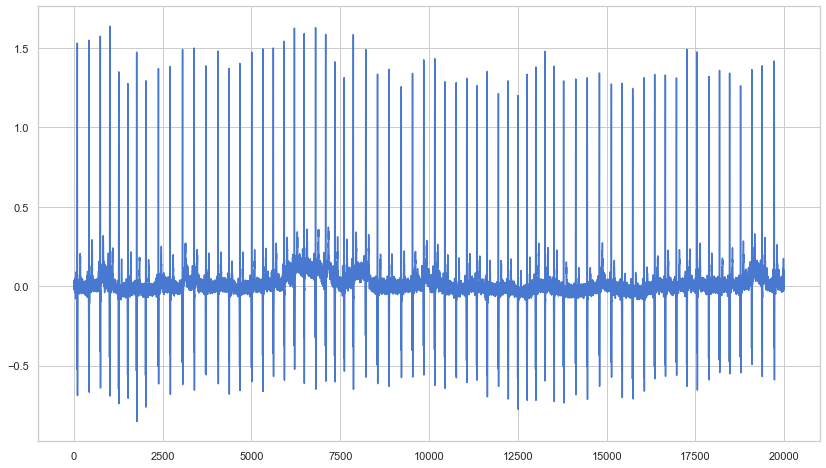

In [43]:
for rec in records_abnormal:
    plt.plot(error[rec])
    break

### c) i) Average of the entire 10 predicted values

In [181]:
avg={}
for rec in records:
    avg[rec]=[]
    for j in range(len(error[rec][0])):
        sum_=0
#         avg[rec][j]=[]
        for i in range(10):
            sum_ += error[rec][i][j]
        avg[rec].append(float(sum_/len(error[rec][0])))

#### d) c) Take 10 prev and 10 next from max error point -> select e^(t-10)<= e^(t) <= e^(t+10)

In [205]:
prev_pts={}
next_pts={}
for rec in records:
    max_ind = avg[rec].index(max(avg[rec]))
    prev_pts[rec] = avg[rec][max_ind-10:max_ind]
    next_pts[rec] = avg[rec][max_ind:max_ind+10]

### d) Summary Features

#### a) Selecting max 10 and min 10 values

In [206]:
max_,min_={},{}
for rec in records:
    max_[rec] = avg[rec][-10:]
    min_[rec] = avg[rec][:10]

#### b) i) Mean of the avg vector 

In [207]:
mean={}
for rec in records:
    avg[rec] = np.array(avg[rec])
    mean[rec] = np.mean(avg[rec])

#### b) ii) Median of the avg vector

In [208]:
median={}
for rec in records:
    median[rec] = np.median(avg[rec])

#### b) iii) Standard Deviation of the avg vector

In [209]:
std={}
for rec in records:
    std[rec] = np.std(avg[rec])

In [211]:
mean['sel16265.dat'],median['sel16265.dat'],std['sel16265.dat']

(-2.5517576466337437e-05, 2.7704240496897294e-05, 0.0004704645529619097)

### Combined Vector

In [212]:
vector={}
for rec in records:
    vector[rec]=[]
    for i in range(len(max_[rec])):
        vector[rec].append(max_[rec][i])
#     vector[rec].append(max_[rec])
    for i in range(len(min_[rec])):
        vector[rec].append(min_[rec][i])
    vector[rec].append(mean[rec])
    vector[rec].append(median[rec])
    vector[rec].append(std[rec])
    for i in range(len(prev_pts[rec])):
        vector[rec].append(prev_pts[rec][i])
    for i in range(len(next_pts[rec])):
        vector[rec].append(next_pts[rec][i])

In [215]:
len(vector['sel123.dat'])

43

# Models

## 1) Multilayer Perceptron

In [216]:
from sklearn.neural_network import MLPClassifier

In [217]:
mlp = MLPClassifier(hidden_layer_sizes=300)

In [261]:
mlp.fit(vector['sel16265.dat'], [train_label['sel16265.dat']])

MLPClassifier(hidden_layer_sizes=300)

In [336]:
mlp.predict(test_data['sel16265.dat'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [348]:
mlp.score(test_data['sel16265.dat'],test_label['sel16265.dat'])

1.0

In [331]:
test_data['sel16265.dat'] = np.array(test_data['sel16265.dat'])

In [332]:
test_data['sel16265.dat'] = test_data['sel16265.dat'][:-130].reshape(90,43)

In [280]:
test_data['sel16265.dat'] = np.expand_dims(test_data['sel16265.dat'],axis=0)

In [279]:
test_data['sel16265.dat'] = np.squeeze(test_data['sel16265.dat'],axis=1)

In [270]:
vector['sel16265.dat'] = np.squeeze(vector['sel16265.dat'],axis=0)

In [333]:
np.shape(test_data['sel16265.dat']),np.shape(vector['sel16265.dat'])

((90, 43), (1, 43))

In [343]:
test_label['sel16265.dat'] = [test_label['sel16265.dat']]
for i in range(89):
    test_label['sel16265.dat'].append(0)

In [346]:
test_label['sel16265.dat'] = np.array(test_label['sel16265.dat'])

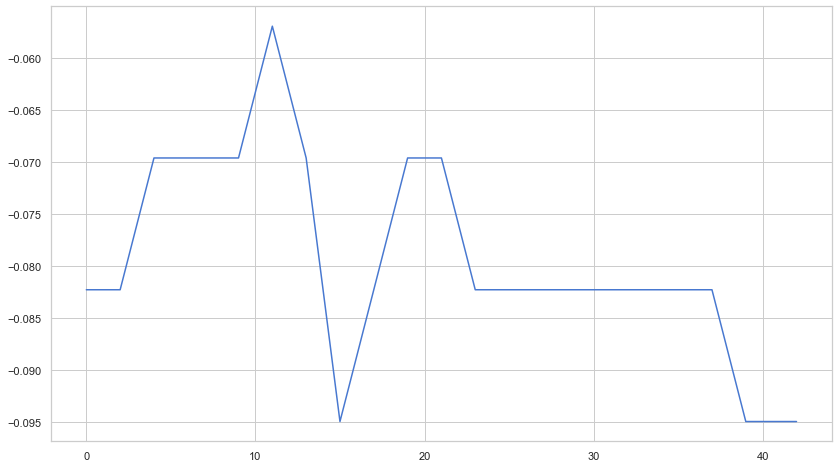

In [356]:
plt.plot(test_data['sel16265.dat'][89])

# Building MLP using pyTorch

In [360]:
import torch

In [362]:
X = torch.tensor([1,2,3])

In [377]:
X = torch.eye(3)

In [381]:
X.add_(5)

tensor([[6., 5., 5.],
        [5., 6., 5.],
        [5., 5., 6.]])

## MLP example

In [283]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, random_state=1)

In [300]:
X_train, X_test = np.array(X_train), np.array(X_test)

In [341]:
np.shape(X_train),np.shape(X_test),np.shape(y_test)

((75, 20), (25, 20), (25,))

In [299]:
test_data['sel16265.dat']

array([[-0.06962025, -0.05696203, -0.0443038 , ..., -0.2278481 ,
        -0.20253165, -0.1835443 ]])

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [285]:
clf.predict_proba(X_test[:1])

array([[0.03838405, 0.96161595]])

In [286]:
clf.predict(X_test[:5, :])

array([1, 0, 1, 0, 1])

In [287]:
clf.score(X_test, y_test)

0.88

## 2) Logistic Regression

## 3) Support Vector Machine